### Шумоподавляющие автоэнкодеры и что с ними делать

В этом примере мы будем обучать глубокие автоэнкодеры и применять их к изображениям лиц, в том числе для поиска похожих.

Изображения лиц представлены датасетом [lfw](http://vis-www.cs.umass.edu/lfw/).

In [1]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


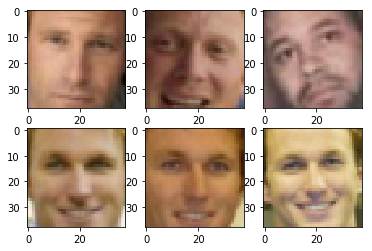

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Архитектура автоэнкодера

Представим автоэнкодер как две последовательных сети: энкодер и декодер.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>

In [3]:
import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm
import sys

use_cuda = torch.cuda.is_available()

## Первый шаг: PCA

Метод главных компонент (Principal component analysis, или PCA) - популярный метод снижения размерности. 

Основой метода является такое разложение матрицы "объект-признак" $X$ на две матрицы меньшего размера: $W$ и $\hat W$, которое минимизирует _среднеквадратичную ошибку_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - Матрица объектов (**центрированная**);
- $W \in \mathbb{R}^{m \times d}$ - Матрица прямого преобразования;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - Матрица обратного преобразования;
- $n$ - количество примеров, $m$ - оригинальная размерность и $d$ - целевая размерность;

В геометрическом смысле, мы хотим выделить $d$ осей, вдоль которых находится большая часть дисперсии. Эти оси также иногда называются "естественными".

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA также может быть рассмотрен как особый случай автоэнкодера.

* __Энкодер__: X -> Linear(d нейронов) -> код
* __Декодер__: код -> Linear(m нейронов) -> X

Где Linear обозначает полносвязный слой с линейной активационной функцией:   $f(X) = W \cdot X + \vec b $

Замечание: в данных слоях смещение предназначено для вычета средного, или "центрирования" матрицы.

In [4]:
class Encoder(nn.Module):
    def __init__(self, img_shape, code_size=32):
        super(Encoder, self).__init__()
        self.enc = nn.Linear(int(np.prod(img_shape)), code_size)
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        input = self.enc(input)
        return input
    
    
class Decoder(nn.Module):
    def __init__(self, img_shape, code_size=32):
        super(Decoder, self).__init__()
        self.dec = nn.Linear(code_size, int(np.prod(img_shape)))
        
    def forward(self, input):
        input = self.dec(input)
        input = input.view((input.size(0),) + img_shape)
        return input

Объединяем их в одну модель

In [5]:
class Autoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    def __init__(self, img_shape, code_size=32):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(img_shape, code_size)
        self.decoder = Decoder(img_shape, code_size)
        
    def forward(self, input):
        input = self.encoder(input)
        input = self.decoder(input)
        return input

In [6]:
batch_size = 50
code_size = 32

autoencoder = Autoencoder(img_shape, code_size)

inp_image = Variable(torch.FloatTensor((batch_size,) + img_shape))
inp_code = Variable(torch.FloatTensor(batch_size, code_size))

if use_cuda:
    autoencoder.cuda()
    inp_image.cuda()
    inp_code.cuda()
    
autoenc_opt = torch.optim.Adamax(autoencoder.parameters())
autoenc_loss = nn.MSELoss()

In [7]:
def iterate_minibatches(data, batch_size = 32, verbose = True):
    indices = np.random.permutation(np.arange(len(data)))
    batches = range(0, len(data), batch_size)
    if verbose: 
        batches = tqdm(batches)
    return (torch.from_numpy(data[indices[start_idx:start_idx + batch_size]]) for start_idx in batches)

def compute_loss(x_batch):
    autoencoder.eval()
    inp_image.data.resize_(x_batch.size()).copy_(x_batch)
    rec = autoencoder(inp_image)
    err = autoenc_loss(rec, inp_image)
    autoencoder.train()
    return err.data[0]

def evaluate(x):
    val_losses = list(map(compute_loss, iterate_minibatches(x,verbose=False)))
    return np.mean(val_losses)

In [8]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=batch_size):
        autoencoder.zero_grad()
        inp_image.data.resize_(x_batch.size()).copy_(x_batch)
        rec = autoencoder(inp_image)
        err = autoenc_loss(rec, inp_image)
        err.backward()
        autoenc_opt.step()
        losses.append(err.data[0])
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

    print("#%i, Test loss: %.7f"%(epoch+1,evaluate(X_test)),flush=True)

100%|██████████| 237/237 [00:03<00:00, 69.64it/s]

#1, Train loss: 1.5718784


#1, Test loss: 0.0222815


100%|██████████| 237/237 [00:03<00:00, 70.49it/s]

#2, Train loss: 0.0219002


#2, Test loss: 0.0220494


100%|██████████| 237/237 [00:03<00:00, 70.04it/s]

#3, Train loss: 0.0215835


#3, Test loss: 0.0219865


100%|██████████| 237/237 [00:03<00:00, 72.31it/s]

#4, Train loss: 0.0213923
#4, Test loss: 0.0213798



100%|██████████| 237/237 [00:03<00:00, 71.51it/s]

#5, Train loss: 0.0212450
#5, Test loss: 0.0212810



100%|██████████| 237/237 [00:03<00:00, 73.83it/s]

#6, Train loss: 0.0211380


#6, Test loss: 0.0211985


100%|██████████| 237/237 [00:03<00:00, 73.69it/s]

#7, Train loss: 0.0210296


#7, Test loss: 0.0211374


100%|██████████| 237/237 [00:03<00:00, 73.54it/s]

#8, Train loss: 0.0209450


#8, Test loss: 0.0211887


100%|██████████| 237/237 [00:03<00:00, 74.92it/s]

#9, Train loss: 0.0208728


#9, Test loss: 0.0209023


100%|██████████| 237/237 [00:03<00:00, 73.29it/s]

#10, Train loss: 0.0208046


#10, Test loss: 0.0207600


100%|██████████| 237/237 [00:03<00:00, 75.90it/s]

#11, Train loss: 0.0207625


#11, Test loss: 0.0208970


100%|██████████| 237/237 [00:03<00:00, 72.72it/s]

#12, Train loss: 0.0207248


#12, Test loss: 0.0206637


100%|██████████| 237/237 [00:03<00:00, 69.54it/s]

#13, Train loss: 0.0208824


#13, Test loss: 0.0207523


100%|██████████| 237/237 [00:03<00:00, 70.45it/s]

#14, Train loss: 0.0208149


#14, Test loss: 0.0207904


100%|██████████| 237/237 [00:03<00:00, 71.22it/s]

#15, Train loss: 0.0212646


#15, Test loss: 0.0205186


100%|██████████| 237/237 [00:03<00:00, 70.85it/s]

#16, Train loss: 0.0267482


#16, Test loss: 0.0263672


100%|██████████| 237/237 [00:03<00:00, 70.03it/s]

#17, Train loss: 0.0290416
#17, Test loss: 0.0374777



100%|██████████| 237/237 [00:03<00:00, 69.20it/s]

#18, Train loss: 0.0273437


#18, Test loss: 0.0211343


100%|██████████| 237/237 [00:03<00:00, 70.09it/s]

#19, Train loss: 0.0264361


#19, Test loss: 0.0298156


100%|██████████| 237/237 [00:04<00:00, 55.72it/s]

#20, Train loss: 0.0238033


#20, Test loss: 0.0172546


100%|██████████| 237/237 [00:03<00:00, 74.06it/s]

#21, Train loss: 0.0218173


#21, Test loss: 0.0196451


100%|██████████| 237/237 [00:03<00:00, 74.35it/s]

#22, Train loss: 0.0204734


#22, Test loss: 0.0162910


100%|██████████| 237/237 [00:03<00:00, 71.91it/s]

#23, Train loss: 0.0191889


#23, Test loss: 0.0187082


100%|██████████| 237/237 [00:03<00:00, 74.34it/s]

#24, Train loss: 0.0186820


#24, Test loss: 0.0144834


100%|██████████| 237/237 [00:03<00:00, 73.20it/s]


#25, Train loss: 0.0174737
#25, Test loss: 0.0133430


100%|██████████| 237/237 [00:03<00:00, 67.64it/s]

#26, Train loss: 0.0138023


#26, Test loss: 0.0268825


100%|██████████| 237/237 [00:03<00:00, 72.82it/s]

#27, Train loss: 0.0136099


#27, Test loss: 0.0146171


100%|██████████| 237/237 [00:03<00:00, 73.43it/s]

#28, Train loss: 0.0121617


#28, Test loss: 0.0097393


100%|██████████| 237/237 [00:03<00:00, 74.23it/s]

#29, Train loss: 0.0109856


#29, Test loss: 0.0100316


100%|██████████| 237/237 [00:03<00:00, 72.82it/s]

#30, Train loss: 0.0093589


#30, Test loss: 0.0115444


100%|██████████| 237/237 [00:03<00:00, 74.12it/s]

#31, Train loss: 0.0091999


#31, Test loss: 0.0109265


100%|██████████| 237/237 [00:03<00:00, 73.46it/s]

#32, Train loss: 0.0075243


#32, Test loss: 0.0071655


In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    inp_image.data.resize_(img[None].shape).copy_(torch.from_numpy(img[None]))
    code = encoder(inp_image)
    reco = decoder(code).data.numpy()[0]
    code = code.data.numpy()[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


Final MSE: 0.00718540064104


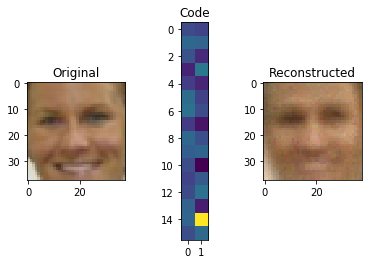

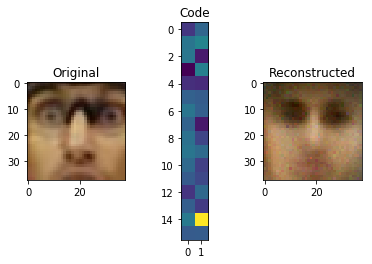

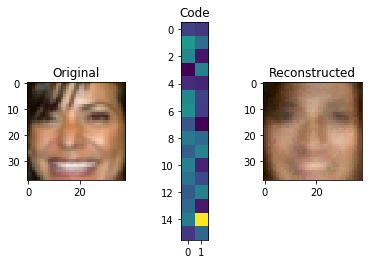

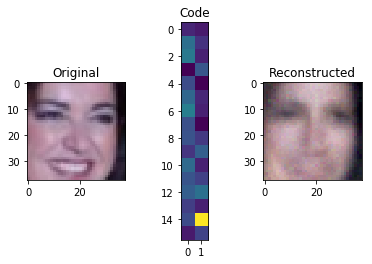

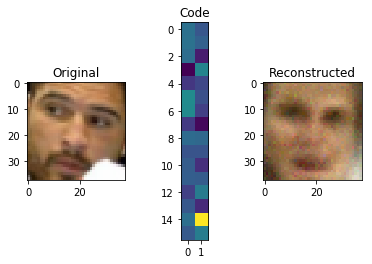

In [10]:
score = evaluate(X_test)
print("Final MSE:",score)

encoder = list(autoencoder.children())[0]
decoder = list(autoencoder.children())[1]

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Отправляемся глубже

PCA уже даёт неплохие результаты, но мы в состоянии добиться лучшего. В этот раз мы построим глубокий автоэнкодер... добавив больше слоёв.

В частности, энкодер и декодер оба должны иметь как минимум 3 слоя. Допускается использование любой активационной функции и любого количества нейронов в слоях (кроме слоя с кодом). Сеть не должна быть слишком большой, чтобы её тренировка занимала не так много времени.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

Проверьте:
* Не должно быть скрытых слоёв размером меньше, чем слой с кодом (выходной слой энкодера).
* Не забывайте добавлять нелинейность между полносвязными слоями.
* Использование свёрточных сетей допускается, но не является необходимым. Чтобы отменить операцию свёртки используйте nn.ConvTranspose2d, операцию подвыборки (pooling) - nn.UpsamplingBilinear2d.
* Добавление активационной функции после слоя с кодом допускается, но не является строго необходимым.

In [11]:
class DeepEncoder(nn.Module):
    def __init__(self, img_shape, code_size=32):
        super(DeepEncoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), code_size*4),
            nn.Linear(code_size*4, code_size*2),
            nn.Linear(code_size*2, code_size),
        )
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        input = self.enc(input)
        return input
    
    
class DeepDecoder(nn.Module):
    def __init__(self, img_shape, code_size=32):
        super(DeepDecoder, self).__init__()
        self.dec = nn.Sequential(
            nn.Linear(code_size, code_size*2),
            nn.Linear(code_size*2, code_size*4),
            nn.Linear(code_size*4, int(np.prod(img_shape))),
        )
        
    def forward(self, input):
        input = self.dec(input)
        input = input.view((input.size(0),) + img_shape)
        return input
    
    
class DeepAutoencoder(nn.Module):
    def __init__(self, img_shape, code_size=32):
        super(DeepAutoencoder, self).__init__()
        self.encoder = DeepEncoder(img_shape, code_size)
        self.decoder = Decoder(img_shape, code_size)
        
    def forward(self, input):
        input = self.encoder(input)
        input = self.decoder(input)
        return input

In [12]:
#Check autoencoder shapes along different code_sizes
for code_size in [1,8,32,128,512,1024]:
    encoder = DeepEncoder(img_shape, code_size)
    decoder = DeepDecoder(img_shape, code_size)
    encoder_layers = list(encoder.children())[0]
    decoder_layers = list(decoder.children())[0]
    print("Testing code size %i" % code_size)
    assert list(encoder_layers.children())[-1].out_features==code_size, "encoder must output a code of required size"
    assert list(decoder_layers.children())[-1].out_features==np.prod(img_shape), "decoder must output an image of valid shape"
    assert len(list(encoder.parameters()))>=6,     "encoder must contain at least 3 dense layers"
    assert len(list(decoder.parameters()))>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder_layers:
        if type(layer) == nn.Linear:
            assert layer.out_features >= code_size, "Encoder layer %s is smaller than bottleneck"%(layer)
    
    for layer in decoder_layers:
        if type(layer) == nn.Linear:
            assert layer.out_features >= code_size, "Decoder layer %s is smaller than bottleneck"%(layer)

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Подсказка:__ Если вы получаете ошибку "Encoder layer is smaller than bottleneck", используйте переменную code_size при объявлении промежуточных слоёв. 

Например, такой слой может содержать code_size*2 нейронов.

In [13]:
batch_size = 50
code_size = 32

autoencoder = DeepAutoencoder(img_shape, code_size)

inp_image = Variable(torch.FloatTensor((batch_size,) + img_shape))
inp_code = Variable(torch.FloatTensor(batch_size, code_size))

if use_cuda:
    autoencoder.cuda()
    inp_image.cuda()
    inp_code.cuda()
    
autoenc_opt = torch.optim.Adamax(autoencoder.parameters())
autoenc_loss = nn.MSELoss()

Обучение может потребовать около 20 минут.

In [14]:
for epoch in range(32):
    losses = []
    for x_batch in iterate_minibatches(X_train,batch_size=batch_size):
        autoencoder.zero_grad()
        inp_image.data.resize_(x_batch.size()).copy_(x_batch)
        rec = autoencoder(inp_image)
        err = autoenc_loss(rec, inp_image)
        err.backward()
        autoenc_opt.step()
        losses.append(err.data[0])
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

    print("#%i, Test loss: %.7f"%(epoch+1,evaluate(X_test)),flush=True)

100%|██████████| 237/237 [00:06<00:00, 35.79it/s]

#1, Train loss: 0.6007433


#1, Test loss: 0.0468643


100%|██████████| 237/237 [00:06<00:00, 34.94it/s]

#2, Train loss: 0.0309148


#2, Test loss: 0.0235153


100%|██████████| 237/237 [00:06<00:00, 37.05it/s]

#3, Train loss: 0.0220868


#3, Test loss: 0.0215571


100%|██████████| 237/237 [00:06<00:00, 35.85it/s]

#4, Train loss: 0.0212343


#4, Test loss: 0.0211572


100%|██████████| 237/237 [00:06<00:00, 36.42it/s]

#5, Train loss: 0.0210889


#5, Test loss: 0.0212045


100%|██████████| 237/237 [00:06<00:00, 36.21it/s]

#6, Train loss: 0.0230680


#6, Test loss: 0.0212927


100%|██████████| 237/237 [00:06<00:00, 35.77it/s]

#7, Train loss: 0.0240141


#7, Test loss: 0.0212385


100%|██████████| 237/237 [00:06<00:00, 36.44it/s]

#8, Train loss: 0.0230225


#8, Test loss: 0.0229875


100%|██████████| 237/237 [00:06<00:00, 36.33it/s]

#9, Train loss: 0.0250934


#9, Test loss: 0.0216119


100%|██████████| 237/237 [00:06<00:00, 36.37it/s]

#10, Train loss: 0.0238383


#10, Test loss: 0.0217213


100%|██████████| 237/237 [00:07<00:00, 31.02it/s]

#11, Train loss: 0.0220453


#11, Test loss: 0.0197548


100%|██████████| 237/237 [00:06<00:00, 35.52it/s]

#12, Train loss: 0.0211264


#12, Test loss: 0.0283406


100%|██████████| 237/237 [00:06<00:00, 35.77it/s]

#13, Train loss: 0.0193183


#13, Test loss: 0.0183270


100%|██████████| 237/237 [00:06<00:00, 36.18it/s]

#14, Train loss: 0.0182165


#14, Test loss: 0.0192734


100%|██████████| 237/237 [00:06<00:00, 35.83it/s]

#15, Train loss: 0.0166709


#15, Test loss: 0.0156868


100%|██████████| 237/237 [00:06<00:00, 36.49it/s]

#16, Train loss: 0.0159316


#16, Test loss: 0.0171334


100%|██████████| 237/237 [00:06<00:00, 35.83it/s]

#17, Train loss: 0.0142454


#17, Test loss: 0.0147703


100%|██████████| 237/237 [00:06<00:00, 36.65it/s]

#18, Train loss: 0.0136452


#18, Test loss: 0.0132157


100%|██████████| 237/237 [00:06<00:00, 36.67it/s]

#19, Train loss: 0.0135418


#19, Test loss: 0.0162794


100%|██████████| 237/237 [00:06<00:00, 36.62it/s]

#20, Train loss: 0.0121570


#20, Test loss: 0.0115952


100%|██████████| 237/237 [00:06<00:00, 35.10it/s]

#21, Train loss: 0.0114231


#21, Test loss: 0.0112073


100%|██████████| 237/237 [00:06<00:00, 36.67it/s]

#22, Train loss: 0.0113301


#22, Test loss: 0.0109310


100%|██████████| 237/237 [00:06<00:00, 35.22it/s]

#23, Train loss: 0.0098661


#23, Test loss: 0.0097576


100%|██████████| 237/237 [00:07<00:00, 33.41it/s]

#24, Train loss: 0.0095322


#24, Test loss: 0.0091559


100%|██████████| 237/237 [00:06<00:00, 33.99it/s]

#25, Train loss: 0.0097366


#25, Test loss: 0.0086661


100%|██████████| 237/237 [00:07<00:00, 30.40it/s]

#26, Train loss: 0.0083149


#26, Test loss: 0.0084255


100%|██████████| 237/237 [00:06<00:00, 36.83it/s]

#27, Train loss: 0.0094676


#27, Test loss: 0.0081118


100%|██████████| 237/237 [00:05<00:00, 43.54it/s]

#28, Train loss: 0.0076336
#28, Test loss: 0.0075509



100%|██████████| 237/237 [00:06<00:00, 37.78it/s]

#29, Train loss: 0.0072686


#29, Test loss: 0.0072634


100%|██████████| 237/237 [00:05<00:00, 44.10it/s]

#30, Train loss: 0.0070283
#30, Test loss: 0.0069589



100%|██████████| 237/237 [00:05<00:00, 44.87it/s]

#31, Train loss: 0.0068151


#31, Test loss: 0.0067673


100%|██████████| 237/237 [00:05<00:00, 44.87it/s]

#32, Train loss: 0.0077410


#32, Test loss: 0.0065817


In [15]:
reconstruction_mse = evaluate(X_test)
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
print("Final MSE:", reconstruction_mse)

encoder = list(autoencoder.children())[0]
decoder = list(autoencoder.children())[1]

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

AssertionError: Compression is too lossy. See tips below.

__Подсказка:__ Если вы получаете ошибку "Compression to lossy", вот несколько вещей, которые можно попробовать:

* Убедитесь, что процесс обучения сошёлся. Некоторые архитектуры могут потребовать для этого гораздо больше, чем 32 эпохи. Процесс обучения и метрика могут колебаться, но рано или поздно её значания станут достаточно хорошими для прохождения проверки. Можете тренировать сеть столько, сколько для этого потребуется.

* Сложность архитектуры. Если у вас уже, например, 152 слоя, и вы всё ещё не проходите проверку, начните с чего-то более простого и постепенно усложняйте архитекруру.

* Архитектура. Вы можете использовать любую комбинацию слоёв (включая свёрточные, нормализационные и так далее) до тех пор, пока __выходной слой энкодера содержит только 32 числа на обучающий пример__.

## Шумоподавляющие автоэнкодера

Превратим нашу модель в шумоподавляющий автоэнкодер.

Мы сохраним архитектуру модели неизменной, но внесём изменения в процесс её работы. В частности, мы внесём случайную ошибку в её входные данные перед началом каждой эпохи.

Есть много методов зашумления. Мы имплементируем два популярных: добавление гауссового шума и дропаута.

In [16]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = np.random.normal(scale=sigma, size=X.shape)
    return X + noise
    

In [17]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

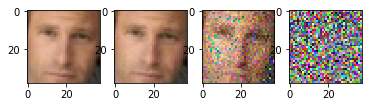

In [18]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [37]:
batch_size=50
code_size=512

autoencoder = DeepAutoencoder(img_shape, code_size=code_size)

inp_image = Variable(torch.FloatTensor((batch_size,) + img_shape))
inp_code = Variable(torch.FloatTensor(batch_size, code_size))

if use_cuda:
    autoencoder.cuda()
    inp_image.cuda()
    inp_code.cuda()
    
autoenc_opt = torch.optim.Adamax(autoencoder.parameters())
autoenc_loss = nn.MSELoss()

In [38]:
for epoch in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%epoch)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    losses = []
    
    for x_batch in iterate_minibatches(X_train_noise,batch_size=batch_size):
        autoencoder.zero_grad()
        inp_image.data.resize_(x_batch.size()).copy_(x_batch)
        rec = autoencoder(inp_image)
        err = autoenc_loss(rec, inp_image)
        err.backward()
        autoenc_opt.step()
        losses.append(err.data[0])
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

    print("#%i, Test loss: %.7f"%(epoch+1,evaluate(X_test_noise)),flush=True)

Epoch 0/50, Generating corrupted samples...


KeyboardInterrupt: 

__Замечание:__ Если обучение не сошлось, увеличьте количество итераций.

__Дополнительное задание:__ Замените гауссов шум на перекрытие случайных прямогугольников на изображении.

Final MSE: 0.291840689523


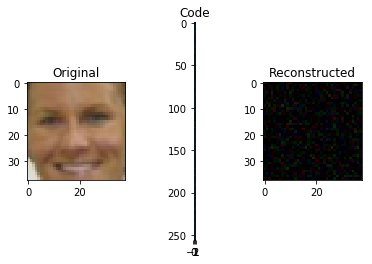

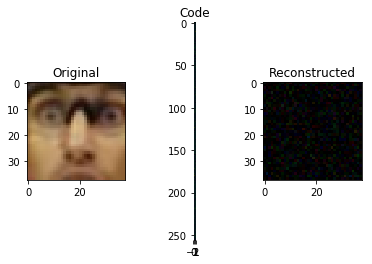

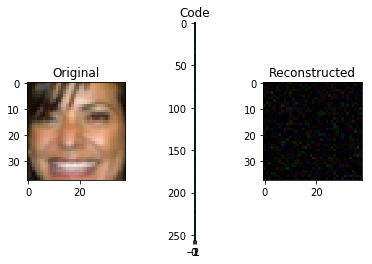

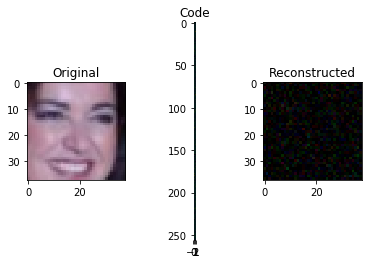

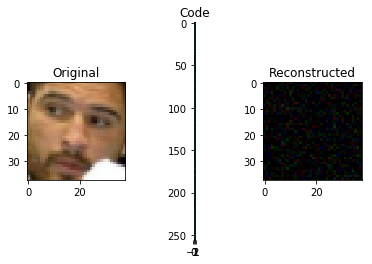

In [39]:
denoising_mse = evaluate(X_test)
print("Final MSE:", denoising_mse)

encoder = list(autoencoder.children())[0]
decoder = list(autoencoder.children())[1]

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

### Поиск изображений при помощи автоэнкодеров

Мы только что обучили сеть, которая преобразует изображение само в себя с ошибкой. Эта задача не столько полезна сама по себе, но она обладает рядом полезных побочных эффектов. Изучим их в действии.

В первую очередь мы можем осуществлять поиск изображений. Имея изображения, мы хотим найти похожие используя код в латентном пространстве.

Чтобы ускорить процесс поиска, мы будем использовать Locality-Sensitive Hashing с закодированными векторами. Мы будем использовать имплементацию из scikit-learn для простоты. В реальных условиях, вам скорее всего потребуется использовать [специализированные библиотеки](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) для большей производительности и поддержки дополнительных настроек.

In [40]:
def compute_codes(images):
    codes = np.zeros([images.shape[0], code_size])
    for i, image in enumerate(images):
        image = Variable(torch.from_numpy(image[None]))
        codes[i] = encoder(image).data.numpy()[0]
    return codes

images = X_train
codes = compute_codes(images)
assert len(codes) == len(images)

In [41]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [45]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    
    image = Variable(torch.from_numpy(image[None]))
    code = encoder(image).data.numpy()[0]
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [46]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

/home/oleg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


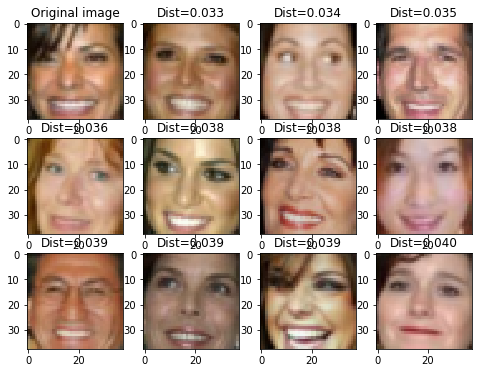

In [47]:
#smiles
show_similar(X_test[2])

/home/oleg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


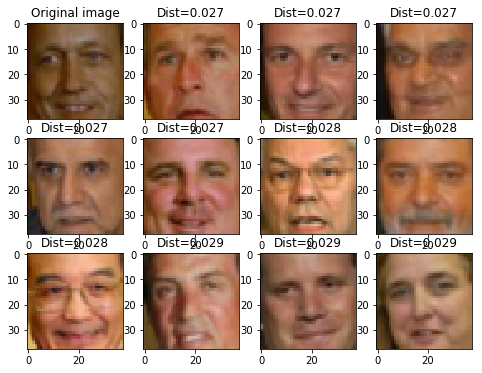

In [48]:
#ethnicity
show_similar(X_test[500])

/home/oleg/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


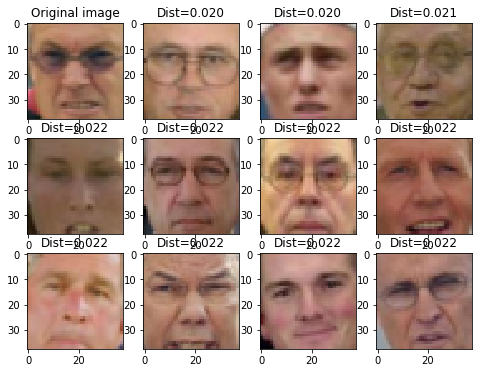

In [49]:
#glasses
show_similar(X_test[66])

## Бонус: простое преобразование изображений


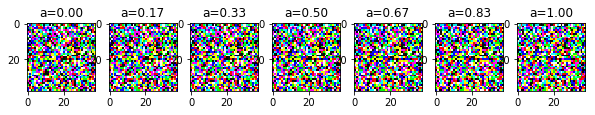

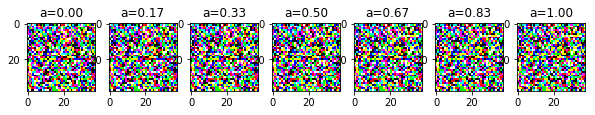

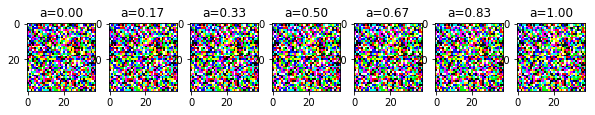

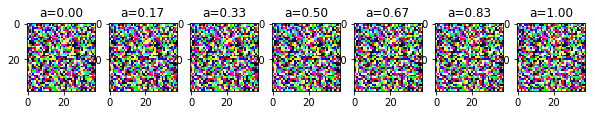

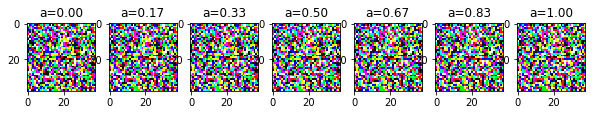

In [54]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]
    code1, code2 = encoder(Variable(torch.from_numpy(np.stack([image1,image2])))).data.numpy()

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_code = Variable(torch.from_numpy(output_code[None]))
        output_image = decoder(output_code).data.numpy()[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Есть и много других применений автоэнкодеров.

Тем не менее, они не совсем подходят для генерации изображений. Для этого лучше использовать генеративно-состязательные сети.